In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [2]:
# This converter function will convert the string into corresponding value.
def converter1(x):
    if x == b'O':       
        return 1
    else:
        return 0

In [3]:
column1 = 0

data = np.loadtxt('letter-recognition.data', delimiter=',', 
               converters={column1:converter1})

In [4]:
print(data)
print(data.shape)

[[  0.   2.   8. ...,   8.   0.   8.]
 [  0.   5.  12. ...,   8.   4.  10.]
 [  0.   4.  11. ...,   7.   3.   9.]
 ..., 
 [  0.   6.   9. ...,  12.   2.   4.]
 [  0.   2.   3. ...,   9.   5.   8.]
 [  0.   4.   9. ...,   7.   2.   8.]]
(20000, 17)


In [5]:
# Divide data into training and testing sets
X_and_Y = data
np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
X = X_and_Y[:5000,1:17]
Y = X_and_Y[:5000,0]
print(X.shape, Y.shape)

(5000, 16) (5000,)


In [6]:
X_train_val = X[:int(0.5*len(X))]
X_test      = X[int(0.5*len(X)):]
Y_train_val = Y[:int(0.5*len(Y))]
Y_test      = Y[int(0.5*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(2500, 16) (2500, 16) (2500,) (2500,)


In [7]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  1.04075432e-02,   1.18088722e-02,   1.47103310e-02,
          1.62110329e-02,   1.41477108e-02,   1.48105621e-02,
          2.23158836e-02,   6.59467220e-02,   3.88644314e-01,
          3.95339375e+00,   4.16530551e+01]),
 'mean_score_time': array([ 0.00230179,  0.00270152,  0.00360203,  0.0031014 ,  0.00276461,
         0.00300226,  0.00380273,  0.007305  ,  0.0071137 ,  0.00870905,
         0.00970812]),
 'mean_test_score': array([ 0.9636,  0.9636,  0.9636,  0.9636,  0.9636,  0.9636,  0.9636,
         0.9636,  0.9636,  0.9636,  0.9636]),
 'mean_train_score': array([ 0.96360005,  0.96360005,  0.96360005,  0.96360005,  0.96360005,
         0.96360005,  0.96360005,  0.96360005,  0.96360005,  0.96360005,
         0.96360005]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},


In [8]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1e-07}
0.9652


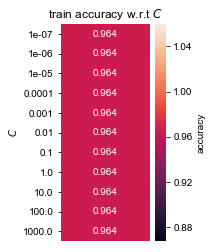

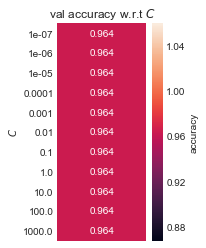

In [11]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [12]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.02331562,  0.02521763,  0.02501774,  0.02331614,  0.02621655,
         0.06574593,  0.03182268,  0.01751246,  0.02661853,  0.02771873,
         0.0278194 ,  0.0328228 ,  0.0246172 ,  0.06584659,  0.03102279,
         0.01690917,  0.03141918,  0.03242292,  0.03192196,  0.03172216,
         0.02982168,  0.06644645,  0.03282351,  0.01951365,  0.03332291,
         0.03162203,  0.03152189,  0.02731819,  0.02751832,  0.07165022,
         0.03642559,  0.02441721,  0.04182997,  0.03602395,  0.03612437,
         0.03562508,  0.03862128,  0.08445892,  0.03592534,  0.02071576,
         0.23026881,  0.22326059,  0.23296742,  0.2199646 ,  0.20534496,
         0.57751265,  0.35855355,  0.06954799,  0.35625482,  0.38630099,
         0.35870275,  0.37507119,  0.37596931,  0.9456769 ,  0.65678301,
         0.19524593,  0.44663448,  0.40819521,  0.42890162,  0.42059464,
         0.41349092,  0.99120564,  0.74383388,  0.27359271,  0.43794513,
         0.42870269,  0.4234035 , 

In [13]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 10.0, 'gamma': 0.125}
0.986


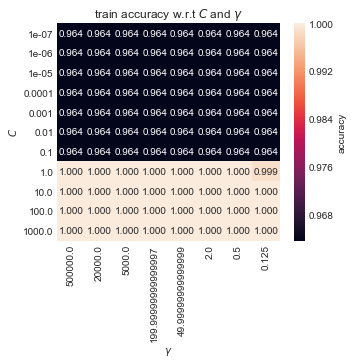

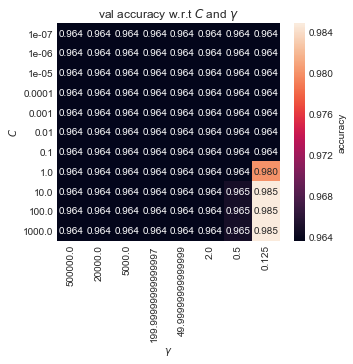

In [15]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [16]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [17]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.98


In [18]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [19]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.9868
